In [ ]:
!pip install gdown librosa

# **1) Dataset download**

In [ ]:
!gdown --fuzzy 'https://drive.google.com/file/d/1nZz6EHYl7M6ReCd7BUHzhuDN52mA36_q/view?usp=drivesdk'

Downloading...
From: https://drive.google.com/uc?id=1nZz6EHYl7M6ReCd7BUHzhuDN52mA36_q
To: /content/gtzan.rar
100% 2.02G/2.02G [00:12<00:00, 162MB/s]


# **2) Decompress Dataset**

In [ ]:
!apt-get update
!apt-get install p7zip-full -y

In [ ]:
!7z e gtzan.rar -odataset_rar
!unrar e dataset_rar/reggae.rar dataset/reggae/
!unrar e dataset_rar/rock.rar dataset/rock/
!unrar e dataset_rar/classical.rar dataset/classical/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2016537100 bytes (1924 MiB)

Extracting archive: gtzan.rar
--
Path = gtzan.rar
Type = Rar
Physical Size = 2016537100
Solid = -
Blocks = 10
Multivolume = -
Volumes = 1

  0%      6% - disco.rar                  9% 1 - hiphop.rar                    13% 1 - hiphop.rar                    18% 2 - jazz.rar                  22% 2 - jazz.rar                  23% 2 - jazz.rar                  24% 2 - jazz.rar                  27% 2 - jazz.rar                 

# **3) Import librairies**

In [ ]:
import os
import numpy
from tensorflow import keras
import librosa
from matplotlib import pyplot

# **4) Feature functions declarations:**

- MFCC
- Mel Spectrogram
- Chroma Vector
- Tonnetz

In [ ]:
def get_mfcc(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  mfcc = numpy.array(librosa.feature.mfcc(y=y, sr=sr))
  return mfcc

In [ ]:
def get_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  melspectrogram = numpy.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

In [ ]:
def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = numpy.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

In [ ]:
def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = numpy.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

# **5) Plot Features as images**

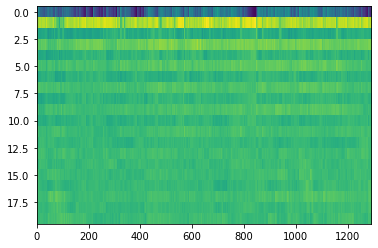

In [ ]:
example_file = "dataset/rock/rock.00085.wav"
mfcc = get_mfcc(example_file)
pyplot.imshow(mfcc, interpolation='nearest', aspect='auto')
pyplot.show()

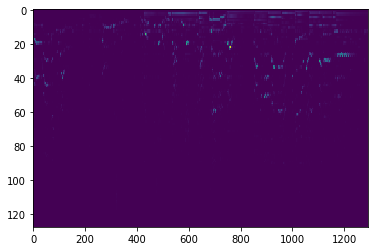

In [ ]:
melspectrogram = get_melspectrogram(example_file)
pyplot.imshow(melspectrogram, interpolation='nearest', aspect='auto')
pyplot.show()

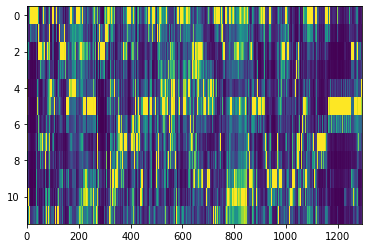

In [ ]:
chroma = get_chroma_vector(example_file)
pyplot.imshow(chroma, interpolation='nearest', aspect='auto')
pyplot.show()

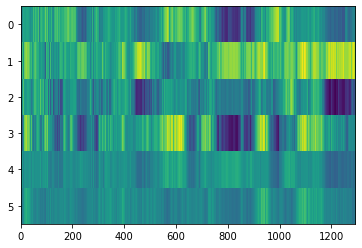

In [ ]:
tntz = get_tonnetz(example_file)
pyplot.imshow(tntz, interpolation='nearest', aspect='auto')
pyplot.show()

# **6) Features calculation**

In [ ]:
def get_feature(file_path):
  # Extracting MFCC feature
  mfcc = get_mfcc(file_path)
  mfcc_mean = mfcc.mean(axis=1)
  mfcc_min = mfcc.min(axis=1)
  mfcc_max = mfcc.max(axis=1)
  mfcc_feature = numpy.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

  # Extracting Mel Spectrogram feature
  melspectrogram = get_melspectrogram(file_path)
  melspectrogram_mean = melspectrogram.mean(axis=1)
  melspectrogram_min = melspectrogram.min(axis=1)
  melspectrogram_max = melspectrogram.max(axis=1)
  melspectrogram_feature = numpy.concatenate( (melspectrogram_mean, melspectrogram_min, melspectrogram_max) )

  # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)
  chroma_min = chroma.min(axis=1)
  chroma_max = chroma.max(axis=1)
  chroma_feature = numpy.concatenate( (chroma_mean, chroma_min, chroma_max) )

  # Extracting tonnetz feature
  tntz = get_tonnetz(file_path)
  tntz_mean = tntz.mean(axis=1)
  tntz_min = tntz.min(axis=1)
  tntz_max = tntz.max(axis=1)
  tntz_feature = numpy.concatenate( (tntz_mean, tntz_min, tntz_max) ) 
  
  feature = numpy.concatenate( (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature) )
  return feature

In [ ]:
directory = 'dataset'
genres = ['reggae','classical','rock']
features = []
labels = []
for genre in genres:
    print("Calculating features for genre : " + genre)
    for file in os.listdir(directory+"/"+genre):
        file_path = directory+"/"+genre+"/"+file

        features.append(get_feature(file_path))
        label = genres.index(genre)
        labels.append(label)

Calculating features for genre : reggae
Calculating features for genre : classical
Calculating features for genre : rock


# **7) Dataset Training Validation Testing Split**

In [ ]:
permutations = numpy.random.permutation(300)
features = numpy.array(features)[permutations]
labels = numpy.array(labels)[permutations]

features_train = features[0:180]
labels_train = labels[0:180]

features_val = features[180:240]
labels_val = labels[180:240]

features_test = features[240:300]
labels_test = labels[240:300]

# **8) Model training**

In [78]:
inputs = keras.Input(shape=(498), name="feature")
x = keras.layers.Dense(300, activation="relu", name="dense_1")(inputs)
x = keras.layers.Dense(200, activation="relu", name="dense_2")(x)
outputs = keras.layers.Dense(3, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    # Optimizer
    optimizer=keras.optimizers.RMSprop(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
model.fit(x=features_train.tolist(),y=labels_train.tolist(),verbose=1,validation_data=(features_val.tolist() , labels_val.tolist()), epochs=64)

Epoch 1/64
6/6 [==============================] - 1s 63ms/step - loss: 79.3231 - sparse_categorical_accuracy: 0.5444 - val_loss: 85.5728 - val_sparse_categorical_accuracy: 0.5333
Epoch 2/64
6/6 [==============================] - 0s 13ms/step - loss: 26.5034 - sparse_categorical_accuracy: 0.7444 - val_loss: 13.5725 - val_sparse_categorical_accuracy: 0.7500
Epoch 3/64
6/6 [==============================] - 0s 14ms/step - loss: 10.2454 - sparse_categorical_accuracy: 0.8222 - val_loss: 20.8187 - val_sparse_categorical_accuracy: 0.7333
Epoch 4/64
6/6 [==============================] - 0s 14ms/step - loss: 8.5751 - sparse_categorical_accuracy: 0.8556 - val_loss: 12.1703 - val_sparse_categorical_accuracy: 0.7833
Epoch 5/64
6/6 [==============================] - 0s 17ms/step - loss: 1.6845 - sparse_categorical_accuracy: 0.9222 - val_loss: 10.2968 - val_sparse_categorical_accuracy: 0.8000
Epoch 6/64
6/6 [==============================] - 0s 13ms/step - loss: 0.2585 - sparse_categorical_accuracy

# **9) Model Evaluation**

In [80]:
score = model.evaluate(x=features_test.tolist(),y=labels_test.tolist(), verbose=0)
print('Accuracy : ' + str(score[1]*100) + '%')

Accuracy : 86.33333134651184%


# **10) Classification of a youtube video**

**Downloading the wav format of the video**

In [ ]:
!pip install youtube-dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.1 MB/s 


In [ ]:
!youtube-dl -x --audio-format wav --output "audio_sample_full.wav" https://www.youtube.com/watch?v=69RdQFDuYPI

[youtube] 69RdQFDuYPI: Downloading webpage
[youtube] 69RdQFDuYPI: Downloading player bc3f94c3
[download] Destination: audio_sample_full.wav
[download] 100% of 3.88MiB in 01:02
[ffmpeg] Post-process file audio_sample_full.wav exists, skipping


**Cropping the wav file to 30s section**

In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydub import AudioSegment
t1 = 60000 #Works in milliseconds
t2 = 90000
waveFile = AudioSegment.from_file("audio_sample_full.wav")
waveFile = waveFile[t1:t2]
waveFile.export('audio_sample_30s.wav', format="wav")

<_io.BufferedRandom name='audio_sample_30s.wav'>

**Predicting the genre**

In [75]:
file_path = "audio_sample_30s.wav"
feature = get_feature(file_path)
y = model.predict(feature.reshape(1,498))
ind = numpy.argmax(y)
genres[ind]

'reggae'